# Building Histograms

### How to run this notebook:
* Give date and type of vehicle as arguments
* If simplified etapas file does not exist, then run RunDailyEtapasBuilder.runSimplifyEtapas(). If it already exists, then omit it
* If simplified perfiles file does not exist, then run RunDailyEtapasBuilder.runSimplifyPerfiles(). If it already exists, then omit it.

Run the builder in this order:
1. etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
2. merged_df = RunDailyEtapasBuilder.includeTorniquetesDate(etapas_df)
3. clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
4. sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime

In [2]:
import RunDailyEtapasBuilder

Enter the date to analyze: 2017-03-01
Enter the vehicle to analyze: BUS
Consider ZP in perfiles file (0/1)?: 0


* Running the builder of the dataframe

In [3]:
#RunDailyEtapasBuilder.runSimplifyEtapas()
etapas_df = RunDailyEtapasBuilder.loadSimplifiedEtapas()
merged_df = RunDailyEtapasBuilder.mergeTurnstileData(etapas_df)
clean_df = RunDailyEtapasBuilder.cleanDataFrame(merged_df)
sorted_df = RunDailyEtapasBuilder.sortDataFrame(clean_df)
sorted_df = sorted_df.reset_index()

Not found in turnstile database: 1614656


* Counting.

In [4]:
print(etapas_df['id'].count())
print(merged_df['id'].count())
print(clean_df['id'].count())
print(sorted_df['id'].count())

2329229
2329229
2210399
2210399


* Adding necessary attributes

In [5]:
sorted_df['mismo_paradero'] = (sorted_df['par_subida']==sorted_df['par_subida'].shift()).fillna(False)
sorted_df['misma_patente'] = (sorted_df['sitio_subida']==sorted_df['sitio_subida'].shift()).fillna(False)
sorted_df['mismo_servicio'] = (sorted_df['servicio_subida']==sorted_df['servicio_subida'].shift()).fillna(False)

sorted_df.loc[(sorted_df.mismo_servicio == True) & (sorted_df.mismo_paradero == True) & (sorted_df.misma_patente == True), 'diferencia_tiempo'] = (sorted_df['t_subida']-sorted_df['t_subida'].shift())

sorted_df['diferencia_tiempo_secs'] = sorted_df['diferencia_tiempo'].dt.total_seconds()
sorted_df['si_torniquete'] = (sorted_df['fecha_instalacion']<=sorted_df['t_subida'])
sorted_df['si_2017_torniquete'] = ((sorted_df['fecha_instalacion']<=sorted_df['t_subida'])&(sorted_df['fecha_instalacion']>=pd.to_datetime('2017-01-01')))

* Filtering by mismo_paradero, misma_patente and by si_torniquete. This is a key part

In [6]:
filtered_df = sorted_df[(sorted_df.mismo_servicio==True) & (sorted_df.mismo_paradero==True) & (sorted_df.misma_patente==True)]
filtered_turnstile_df = filtered_df[filtered_df.si_2017_torniquete==True]
filtered_no_turnstile_df = filtered_df[filtered_df.si_torniquete==False]

* Counting and checking

In [7]:
print(filtered_df['id'].count())
print(filtered_turnstile_df['id'].count())
print(filtered_no_turnstile_df['id'].count())
checking = filtered_turnstile_df['id'].count() + filtered_no_turnstile_df['id'].count()
print(checking)

1380484
30482
1095461
1125943


* Getting rid of unecessary dataframes

In [8]:
del etapas_df
del merged_df
del clean_df

TODO: Currently, there are rows with extremely high values for the 'diferencia_tiempo' attribute (e.g. >=25 mins). <strong>Be aware of this</strong>. <strike>This should be fixed considering the idExpedicion attribute present in the corresponding 'perfiles' database. The following graphs and descriptive statistics consider only the 95th percentile for the 'diferencia_tiempo_secs' attribute.</strike>

### Filtering by diferencia_tiempo<=97th percentile in the corresponding databases. <font color="red">BE AWARE.</font>

In [9]:
turnstile_97 = filtered_turnstile_df.diferencia_tiempo.quantile(0.97)
print ('Percentile 97th for 2017-turnstile database is: ' + str(turnstile_97))
no_turnstile_97 = filtered_no_turnstile_df.diferencia_tiempo.quantile(0.97)
print('Percentile 97th for without_turnstile database is: ' + str(no_turnstile_97))

Percentile 97th for 2017-turnstile database is: 0 days 00:00:43
Percentile 97th for without_turnstile database is: 0 days 00:00:40


In [10]:
turnstile_97_df = filtered_turnstile_df[filtered_turnstile_df.diferencia_tiempo<=turnstile_97]

In [11]:
no_turnstile_97_df = filtered_no_turnstile_df[filtered_no_turnstile_df.diferencia_tiempo<=no_turnstile_97]

In [13]:
turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,2.957900e+04,2.957900e+04,29579.000000,29579,29579.000000
mean,1.176877e+06,2.265448e+09,1.558775,0 days 00:00:06.473274,6.473275
std,6.778374e+05,1.303380e+09,0.822024,0 days 00:00:05.615842,5.615842
min,1.130000e+02,8.434730e+06,1.000000,0 days 00:00:00,0.000000
25%,5.906465e+05,9.917933e+08,1.000000,0 days 00:00:04,4.000000
50%,1.190598e+06,2.525642e+09,1.000000,0 days 00:00:05,5.000000
75%,1.766735e+06,3.461605e+09,2.000000,0 days 00:00:07,7.000000
max,2.329088e+06,4.287640e+09,14.000000,0 days 00:00:43,43.000000


In [14]:
no_turnstile_97_df.describe()

,index,id,nviaje,diferencia_tiempo,diferencia_tiempo_secs
count,1.063089e+06,1.063089e+06,1.063089e+06,1063089,1.063089e+06
mean,1.169302e+06,2.251981e+09,1.637393e+00,0 days 00:00:03.932738,3.932738e+00
std,6.719147e+05,1.294548e+09,8.616745e-01,0 days 00:00:05.192272,5.192272e+00
min,0.000000e+00,5.454520e+05,1.000000e+00,0 days 00:00:00,0.000000e+00
25%,5.845640e+05,9.356767e+08,1.000000e+00,0 days 00:00:02,2.000000e+00
50%,1.170424e+06,2.512576e+09,1.000000e+00,0 days 00:00:03,3.000000e+00
75%,1.752285e+06,3.418036e+09,2.000000e+00,0 days 00:00:04,4.000000e+00
max,2.329226e+06,4.293302e+09,1.900000e+01,0 days 00:00:40,4.000000e+01


* Plotting

In [15]:
turns_vals = turnstile_97_df.diferencia_tiempo_secs.values
no_turns_vals = no_turnstile_97_df.diferencia_tiempo_secs.values
max_97 = max(turnstile_97,no_turnstile_97).total_seconds()
bins = range(0,int(max_97),1)

In [17]:
colors = [(85,98,112),(78,205,196),(199,244,100),(255,107,107),(196,77,88)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

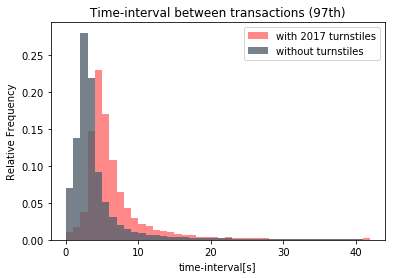

In [22]:
hist_fig, ax = plt.subplots()

plot1 = ax.hist(turns_vals,normed=True,bins=bins,color=colors[3], alpha=0.8, label='with 2017 turnstiles')
plot2 = ax.hist(no_turns_vals,normed=True,bins=bins,color=colors[0], alpha = 0.8, label='without turnstiles')


ax.set_title('Time-interval between transactions (97th)')
ax.set_xlabel('time-interval[s]')
ax.set_ylabel('Relative Frequency')
ax.legend()
plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/2_daily2017-07-19.pdf')

In [35]:
import scipy as sp
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m, m+h

In [36]:
mean_confidence_interval(turnstile_97_df['diferencia_tiempo_secs'])

(6.4092736255493188, 6.473274958585483, 6.5372762916216471)

In [30]:
mean_confidence_interval(no_turnstile_97_df['diferencia_tiempo_secs'])

(3.9228683702201921, 3.932738463101396, 3.9426085559825998)